In [2]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Smith is looking for a job"])
v.vocabulary_

{'thor': 5, 'smith': 4, 'is': 1, 'looking': 3, 'for': 0, 'job': 2}

In [3]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Smith is looking for a job"])
v.vocabulary_

{'thor': 9,
 'smith': 7,
 'is': 2,
 'looking': 5,
 'for': 0,
 'job': 4,
 'thor smith': 10,
 'smith is': 8,
 'is looking': 3,
 'looking for': 6,
 'for job': 1}

In [5]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Smith is looking for a job"])
v.vocabulary_

{'thor': 12,
 'smith': 9,
 'is': 2,
 'looking': 6,
 'for': 0,
 'job': 5,
 'thor smith': 13,
 'smith is': 10,
 'is looking': 3,
 'looking for': 7,
 'for job': 1,
 'thor smith is': 14,
 'smith is looking': 11,
 'is looking for': 4,
 'looking for job': 8}

In [6]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return " ".join(filtered_tokens)

In [10]:
preprocess("Thor ate pizza")

'Thor eat pizza'

In [11]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [13]:
corpus_processed = [preprocess(text) for text in corpus]
corpus_processed

['Thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [12]:
for i in corpus:
    print(i)

Thor ate pizza
Loki is tall
Loki is eating pizza


In [14]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [16]:
v.transform(['Thor eat pizza']).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]])

In [17]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

## News Category Classification Problem

In [20]:
import pandas as pd

df = pd.read_json('news_dataset.json')

print(df.shape)

print(df.head())

(12695, 2)
                                                text  category
0  Watching Schrödinger's Cat Die University of C...   SCIENCE
1     WATCH: Freaky Vortex Opens Up In Flooded Lake    SCIENCE
2  Entrepreneurs Today Don't Need a Big Budget to...  BUSINESS
3  These Roads Could Recharge Your Electric Car A...  BUSINESS
4  Civilian 'Guard' Fires Gun While 'Protecting' ...     CRIME


In [21]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

In [23]:
min_samples = 1381

df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [24]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

In [25]:
df_balanced["category_number"] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [26]:
df_balanced.head()

,text,category,category_number
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_number, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_number
)

In [30]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [31]:
X_train[7589]

'Ovulating Women Prefer Images of Penetration Over Images of Oral Sex Canadian researchers found that during ovulation the female genitalia is more responsive to images of penetration than to images of oral sex. The difference is significantly reduced during non-fertile phases of the menstrual cycle.'

In [32]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_number, dtype: int64

In [33]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_number, dtype: int64

### Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1,1))),
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range=(1,2))),
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



In [39]:
df_balanced['Preprocessed_text'] = df_balanced['text'].apply(preprocess)
df_balanced.head()

,text,category,category_number,Preprocessed_text
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,gcc Business leader remain Confident face Regi...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks talk give build ...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_text, 
    df_balanced.category_number, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_number
)

In [43]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1,1))),
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       276
           1       0.92      0.82      0.86       277
           2       0.82      0.91      0.86       276
           3       0.90      0.82      0.86       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[240,   9,  16,  11],
       [  7, 227,  34,   9],
       [ 17,   2, 252,   5],
       [ 33,  10,   7, 226]])

Text(69.0, 0.5, 'Truth')

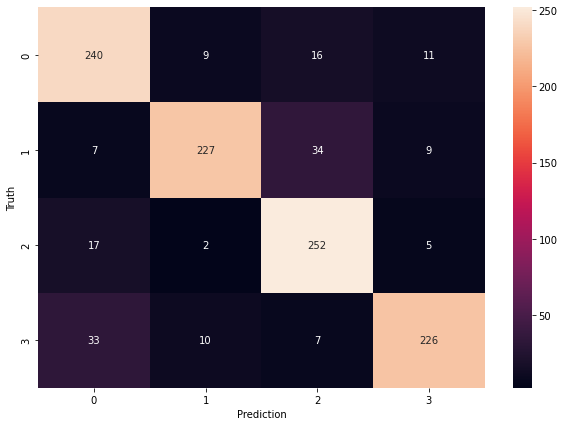

In [47]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')